Loading all datasets...
Combining datasets...
Calculating RUL...
Performing feature engineering...
Preparing data...
Scaling features...
Training Random Forest model...
Making predictions...
Random Forest Test RMSE: 38.016712288092016
Random Forest Test R^2: 0.4459142195273822


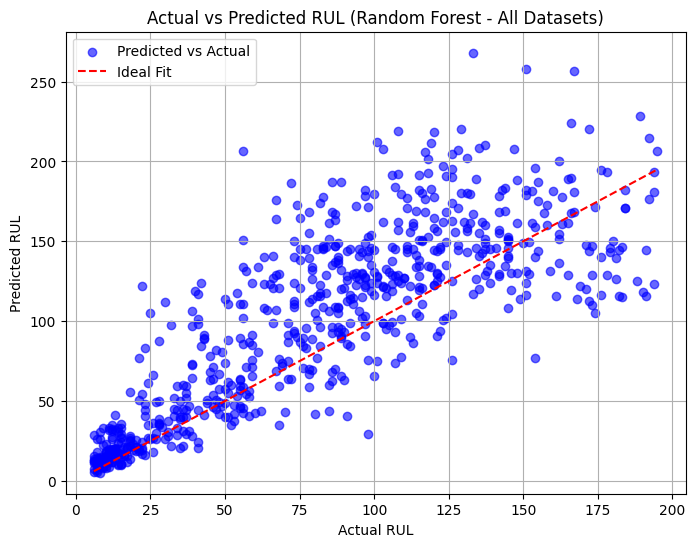


Predicted Class Distribution:
Predicted Classification
Healthy     71.570014
Warning     26.874116
Critical     1.555870

Actual Class Distribution:
Actual Classification
Healthy     67.468175
Warning     27.015559
Critical     5.516266
Results saved to 'rf_all_datasets_predictions_with_classifications.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

# Load all datasets
print("Loading all datasets...")
datasets = ['FD001', 'FD002', 'FD003', 'FD004']
train_files = [f'/content/train_{ds}.txt' for ds in datasets]
test_files = [f'/content/test_{ds}.txt' for ds in datasets]
rul_files = [f'/content/RUL_{ds}.txt' for ds in datasets]

train_dfs = []
test_dfs = []
rul_dfs = []

for i, ds in enumerate(datasets):
    train_df = pd.read_csv(train_files[i], sep="\s+", header=None)
    test_df = pd.read_csv(test_files[i], sep="\s+", header=None)
    rul_df = pd.read_csv(rul_files[i], header=None)

    train_df['Dataset'] = ds
    test_df['Dataset'] = ds
    rul_df['Dataset'] = ds

    train_dfs.append(train_df)
    test_dfs.append(test_df)
    rul_dfs.append(rul_df)

# Combine all datasets
print("Combining datasets...")
train_combined = pd.concat(train_dfs, axis=0, ignore_index=True)
test_combined = pd.concat(test_dfs, axis=0, ignore_index=True)
rul_combined = pd.concat(rul_dfs, axis=0, ignore_index=True)

# Assign column names
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_combined.columns = columns + ['Dataset']
test_combined.columns = columns + ['Dataset']
rul_combined.columns = ['RUL', 'Dataset']

# Calculate RUL for training data
print("Calculating RUL...")
train_combined['Max Cycle'] = train_combined.groupby(['Dataset', 'Engine ID'])['Cycle'].transform('max')
train_combined['RUL'] = train_combined['Max Cycle'] - train_combined['Cycle']
train_combined.drop(columns=['Max Cycle'], inplace=True)

# Feature Engineering: Adding rolling statistics
print("Performing feature engineering...")
for dataset in [train_combined, test_combined]:
    for sensor in ['Sensor3', 'Sensor4', 'Sensor9', 'Sensor11', 'Sensor15']:
        dataset[f'{sensor}_rolling_mean'] = dataset.groupby(['Dataset', 'Engine ID'])[sensor].rolling(window=5).mean().reset_index(level=[0, 1], drop=True)
        dataset[f'{sensor}_rolling_std'] = dataset.groupby(['Dataset', 'Engine ID'])[sensor].rolling(window=5).std().reset_index(level=[0, 1], drop=True)
        dataset[f'{sensor}_diff'] = dataset.groupby(['Dataset', 'Engine ID'])[sensor].diff()

# Drop unnecessary columns based on correlation analysis
drop_columns = ['Sensor1', 'Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_combined.drop(columns=drop_columns, inplace=True)
test_combined.drop(columns=drop_columns, inplace=True)

# Prepare training and test data
print("Preparing data...")
X_train = train_combined.drop(columns=['RUL', 'Engine ID', 'Cycle', 'Dataset'])
y_train = train_combined['RUL']

# Use last cycle for each engine in test set
test_last_cycle = test_combined.groupby(['Dataset', 'Engine ID']).last().reset_index()
X_test = test_last_cycle.drop(columns=['Engine ID', 'Cycle', 'Dataset'])
y_test = rul_combined['RUL']

# Ensure feature consistency between train and test sets
features = X_train.columns
X_test = X_test[features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and features
joblib.dump(scaler, 'scaler_all_datasets.pkl')
joblib.dump(features.tolist(), 'features_all_datasets.pkl')

# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Save model
joblib.dump(rf_model, 'rf_model_all_datasets.pkl')

# Make predictions
print("Making predictions...")
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Test RMSE: {rmse}")
print(f"Random Forest Test R^2: {r2}")

# Visualize Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (Random Forest - All Datasets)')
plt.legend()
plt.grid()
plt.show()

# Define RUL Categories
def classify_rul(rul):
    if rul < 10:
        return "Critical"
    elif 10 <= rul <= 50:
        return "Warning"
    else:
        return "Healthy"

# Add Predictions and Classifications
results_df = pd.DataFrame({
    'Dataset': test_last_cycle['Dataset'],
    'Engine ID': test_last_cycle['Engine ID'],
    'Predicted RUL': np.round(y_pred),
    'Actual RUL': y_test
})

results_df['Predicted Classification'] = results_df['Predicted RUL'].apply(classify_rul)
results_df['Actual Classification'] = results_df['Actual RUL'].apply(classify_rul)

# Display Class Distributions
predicted_class_distribution = results_df['Predicted Classification'].value_counts(normalize=True) * 100
actual_class_distribution = results_df['Actual Classification'].value_counts(normalize=True) * 100

print("\nPredicted Class Distribution:")
print(predicted_class_distribution.to_string())
print("\nActual Class Distribution:")
print(actual_class_distribution.to_string())

# Save results to CSV
results_df.to_csv('rf_all_datasets_predictions_with_classifications.csv', index=False)
print("Results saved to 'rf_all_datasets_predictions_with_classifications.csv'.")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Loading all datasets...
Calculating RUL...
Performing feature engineering...
Preparing data...
Scaling features...
Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7620
[LightGBM] [Info] Number of data points in the train set: 160359, number of used features: 32
[LightGBM] [Info] Start training from score 122.331338
Making predictions...
LightGBM Test RMSE: 81.54900687661883
LightGBM Test R^2: -1.5495600523140611


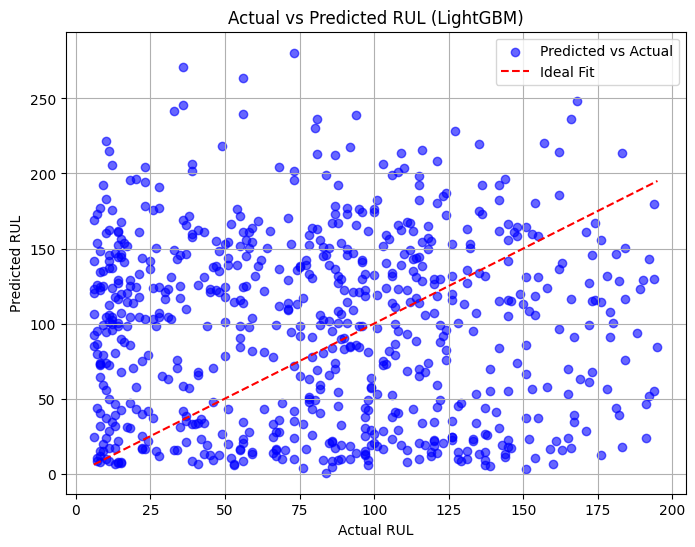

ValueError: All arrays must be of the same length

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib

# Load all datasets
print("Loading all datasets...")
datasets = ['FD001', 'FD002', 'FD003', 'FD004']
train_data_list = []
test_data_list = []
rul_test_list = []

for dataset in datasets:
    train = pd.read_csv(f'/content/train_{dataset}.txt', sep="\s+", header=None)
    test = pd.read_csv(f'/content/test_{dataset}.txt', sep="\s+", header=None)
    rul = pd.read_csv(f'/content/RUL_{dataset}.txt', header=None)

    train['Dataset'] = dataset
    test['Dataset'] = dataset
    train_data_list.append(train)
    test_data_list.append(test)
    rul_test_list.append(rul)

# Combine datasets
train_data = pd.concat(train_data_list, axis=0)
test_data = pd.concat(test_data_list, axis=0)
rul_test = pd.concat(rul_test_list, axis=0).reset_index(drop=True)

# Assign column names
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)] + ['Dataset']
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Calculate RUL for training data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby(['Engine ID', 'Dataset'])['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Feature Engineering: Adding rolling statistics
print("Performing feature engineering...")
for sensor in ['Sensor3', 'Sensor4', 'Sensor9', 'Sensor11', 'Sensor15']:
    for dataset in [train_data, test_data]:
        rolling_group = dataset.groupby(['Engine ID', 'Dataset'])[sensor]
        dataset[f'{sensor}_rolling_mean'] = rolling_group.transform(lambda x: x.rolling(window=5, min_periods=1).mean())
        dataset[f'{sensor}_rolling_std'] = rolling_group.transform(lambda x: x.rolling(window=5, min_periods=1).std())
        dataset[f'{sensor}_diff'] = rolling_group.transform(lambda x: x.diff())

# Drop unnecessary columns based on correlation analysis
drop_columns = ['Sensor1', 'Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Prepare training and test data
print("Preparing data...")
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle', 'Dataset'])
y_train = train_data['RUL']
X_test = test_data.groupby(['Engine ID', 'Dataset']).last().reset_index().drop(columns=['Engine ID', 'Cycle', 'Dataset'])
y_test = rul_test['RUL']

# Ensure feature consistency between train and test sets
features = X_train.columns
X_test = X_test[features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and features
joblib.dump(scaler, 'scaler_all_datasets.pkl')
joblib.dump(features.tolist(), 'features_all_datasets.pkl')

# Train LightGBM model
print("Training LightGBM model...")
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    random_state=42,
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8
)
lgb_model.fit(X_train_scaled, y_train)

# Save model
joblib.dump(lgb_model, 'lgb_model_all_datasets.pkl')

# Make predictions
print("Making predictions...")
y_pred = lgb_model.predict(X_test_scaled)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"LightGBM Test RMSE: {rmse}")
print(f"LightGBM Test R^2: {r2}")

# Visualize Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (LightGBM)')
plt.legend()
plt.grid()
plt.show()

# Define RUL Categories
def classify_rul(rul):
    if rul < 10:
        return "Critical"
    elif 10 <= rul <= 50:
        return "Warning"
    else:
        return "Healthy"

# Add Predictions and Classifications
results_df = pd.DataFrame({
    'Engine ID': test_data['Engine ID'].unique(),
    'Predicted RUL': np.round(y_pred),
    'Actual RUL': y_test
})

results_df['Predicted Classification'] = results_df['Predicted RUL'].apply(classify_rul)
results_df['Actual Classification'] = results_df['Actual RUL'].apply(classify_rul)

# Display Class Distributions
predicted_class_distribution = results_df['Predicted Classification'].value_counts(normalize=True) * 100
actual_class_distribution = results_df['Actual Classification'].value_counts(normalize=True) * 100

print("\nPredicted Class Distribution:")
print(predicted_class_distribution.round(2))
print("\nActual Class Distribution:")
print(actual_class_distribution.round(2))

# Save results to CSV
results_df.to_csv('lgb_all_datasets_predictions_with_classifications.csv', index=False)
print("Results saved to 'lgb_all_datasets_predictions_with_classifications.csv'.")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Loading all datasets...
Calculating RUL...
Performing feature engineering...
Preparing data...
Scaling features...
Training base models...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7620
[LightGBM] [Info] Number of data points in the train set: 160359, number of used features: 32
[LightGBM] [Info] Start training from score 122.331338
Optimizing blending weights...
Optimized Weights: [3.33648350e-01 6.66351650e-01 9.86296131e-21]
Blended Ensemble Test RMSE: 80.85596663649419
Blended Ensemble Test R^2: -1.506409568476827


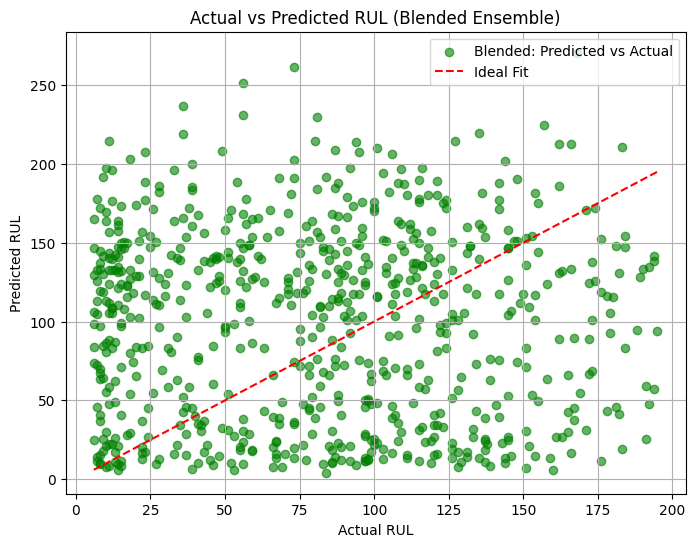


Percentage Distribution of Predicted Classifications:
Predicted Classification
Healthy     71
Warning     27
Critical     2

Percentage Distribution of Actual Classifications:
Actual Classification
Healthy     67
Warning     27
Critical     6
Results with classifications saved to 'blended_ensemble_predicted_vs_actual_rul_combined_with_classifications.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import joblib

# Load all datasets
print("Loading all datasets...")
datasets = ['FD001', 'FD002', 'FD003', 'FD004']
train_data_list = []
test_data_list = []
rul_test_list = []

for dataset in datasets:
    train = pd.read_csv(f'/content/train_{dataset}.txt', sep="\s+", header=None)
    test = pd.read_csv(f'/content/test_{dataset}.txt', sep="\s+", header=None)
    rul = pd.read_csv(f'/content/RUL_{dataset}.txt', header=None)

    train['Dataset'] = dataset
    test['Dataset'] = dataset
    train_data_list.append(train)
    test_data_list.append(test)
    rul_test_list.append(rul)

# Combine datasets
train_data = pd.concat(train_data_list, axis=0)
test_data = pd.concat(test_data_list, axis=0)
rul_test = pd.concat(rul_test_list, axis=0).reset_index(drop=True)

# Assign column names
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)] + ['Dataset']
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Add RUL column to train data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby(['Engine ID', 'Dataset'])['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Feature Engineering: Adding rolling statistics
print("Performing feature engineering...")
for dataset in [train_data, test_data]:
    dataset.reset_index(inplace=True, drop=True)  # Reset the index to avoid duplicate labels
    for sensor in ['Sensor3', 'Sensor4', 'Sensor9', 'Sensor11', 'Sensor15']:
        dataset[f'{sensor}_rolling_mean'] = dataset.groupby(['Engine ID', 'Dataset'])[sensor]\
                                                  .rolling(window=5, min_periods=1).mean().reset_index(level=[0, 1], drop=True)
        dataset[f'{sensor}_rolling_std'] = dataset.groupby(['Engine ID', 'Dataset'])[sensor]\
                                                 .rolling(window=5, min_periods=1).std().reset_index(level=[0, 1], drop=True)
        dataset[f'{sensor}_diff'] = dataset.groupby(['Engine ID', 'Dataset'])[sensor].diff()

# Drop unnecessary columns based on correlation analysis
drop_columns = ['Sensor1', 'Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Prepare training and testing data
print("Preparing data...")
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle', 'Dataset'])
y_train = train_data['RUL']
X_test = test_data.groupby(['Engine ID', 'Dataset']).last().reset_index().drop(columns=['Engine ID', 'Cycle', 'Dataset'])
y_test = rul_test['RUL']

# Align predictions and engine IDs
engine_ids = test_data.groupby(['Engine ID', 'Dataset']).last().reset_index()['Engine ID']

# Ensure feature consistency between train and test sets
features = X_train.columns
X_test = X_test[features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and features for reproducibility
joblib.dump(scaler, 'scaler_combined_datasets.pkl')
joblib.dump(features.tolist(), 'features_combined_datasets.pkl')

# Train Base Models
print("Training base models...")

# XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# LightGBM
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42, n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8)
lgb_model.fit(X_train_scaled, y_train)
lgb_pred = lgb_model.predict(X_test_scaled)

# Blending: Optimize Weights
print("Optimizing blending weights...")

def objective(weights):
    blended_pred = weights[0] * xgb_pred + weights[1] * rf_pred + weights[2] * lgb_pred
    return np.sqrt(mean_squared_error(y_test, blended_pred))

constraints = [{'type': 'eq', 'fun': lambda weights: 1 - sum(weights)}]
bounds = [(0, 1)] * 3
initial_weights = [1/3, 1/3, 1/3]

result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
optimized_weights = result.x
print(f"Optimized Weights: {optimized_weights}")

# Final Blended Prediction
blended_pred = optimized_weights[0] * xgb_pred + optimized_weights[1] * rf_pred + optimized_weights[2] * lgb_pred

# Evaluate the final blended model
blended_rmse = np.sqrt(mean_squared_error(y_test, blended_pred))
blended_r2 = r2_score(y_test, blended_pred)

print(f"Blended Ensemble Test RMSE: {blended_rmse}")
print(f"Blended Ensemble Test R^2: {blended_r2}")

# Visualize Results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, blended_pred, color='green', label='Blended: Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (Blended Ensemble)')
plt.legend()
plt.grid()
plt.show()

# Save predictions to DataFrame
results_df = pd.DataFrame({
    'Engine ID': engine_ids,
    'Blended Predicted RUL': np.round(blended_pred),
    'Actual RUL': y_test
})

# Define RUL Categories
def classify_rul(rul):
    if rul < 10:
        return "Critical"
    elif 10 <= rul <= 50:
        return "Warning"
    else:
        return "Healthy"

# Add Classifications
results_df['Predicted Classification'] = results_df['Blended Predicted RUL'].apply(classify_rul)
results_df['Actual Classification'] = results_df['Actual RUL'].apply(classify_rul)

# Display Percentage Distribution of Classes
predicted_class_distribution = results_df['Predicted Classification'].value_counts(normalize=True) * 100
actual_class_distribution = results_df['Actual Classification'].value_counts(normalize=True) * 100

print("\nPercentage Distribution of Predicted Classifications:")
print(predicted_class_distribution.round(0).astype(int).to_string())
print("\nPercentage Distribution of Actual Classifications:")
print(actual_class_distribution.round(0).astype(int).to_string())

# Save Results with Classifications
results_df.to_csv('blended_ensemble_predicted_vs_actual_rul_combined_with_classifications.csv', index=False)
print("Results with classifications saved to 'blended_ensemble_predicted_vs_actual_rul_combined_with_classifications.csv'.")
